# Ice Hockey Sports Analytics: Harnessing Data for Strategic Advantage

### Analytics in ice hockey encompasses a wide array of metrics and statistics that capture player performance, team dynamics, and game trends. From tracking goal probabilities to analyzing shot locations and assessing player efficiency, data-driven insights provide a comprehensive view of every aspect of the game. By leveraging this wealth of information, teams can:

- Identify patterns and trends
- Tailor strategies to exploit opponents’ weaknesses
- Enhance player development and performance
- Make real-time adjustments during games

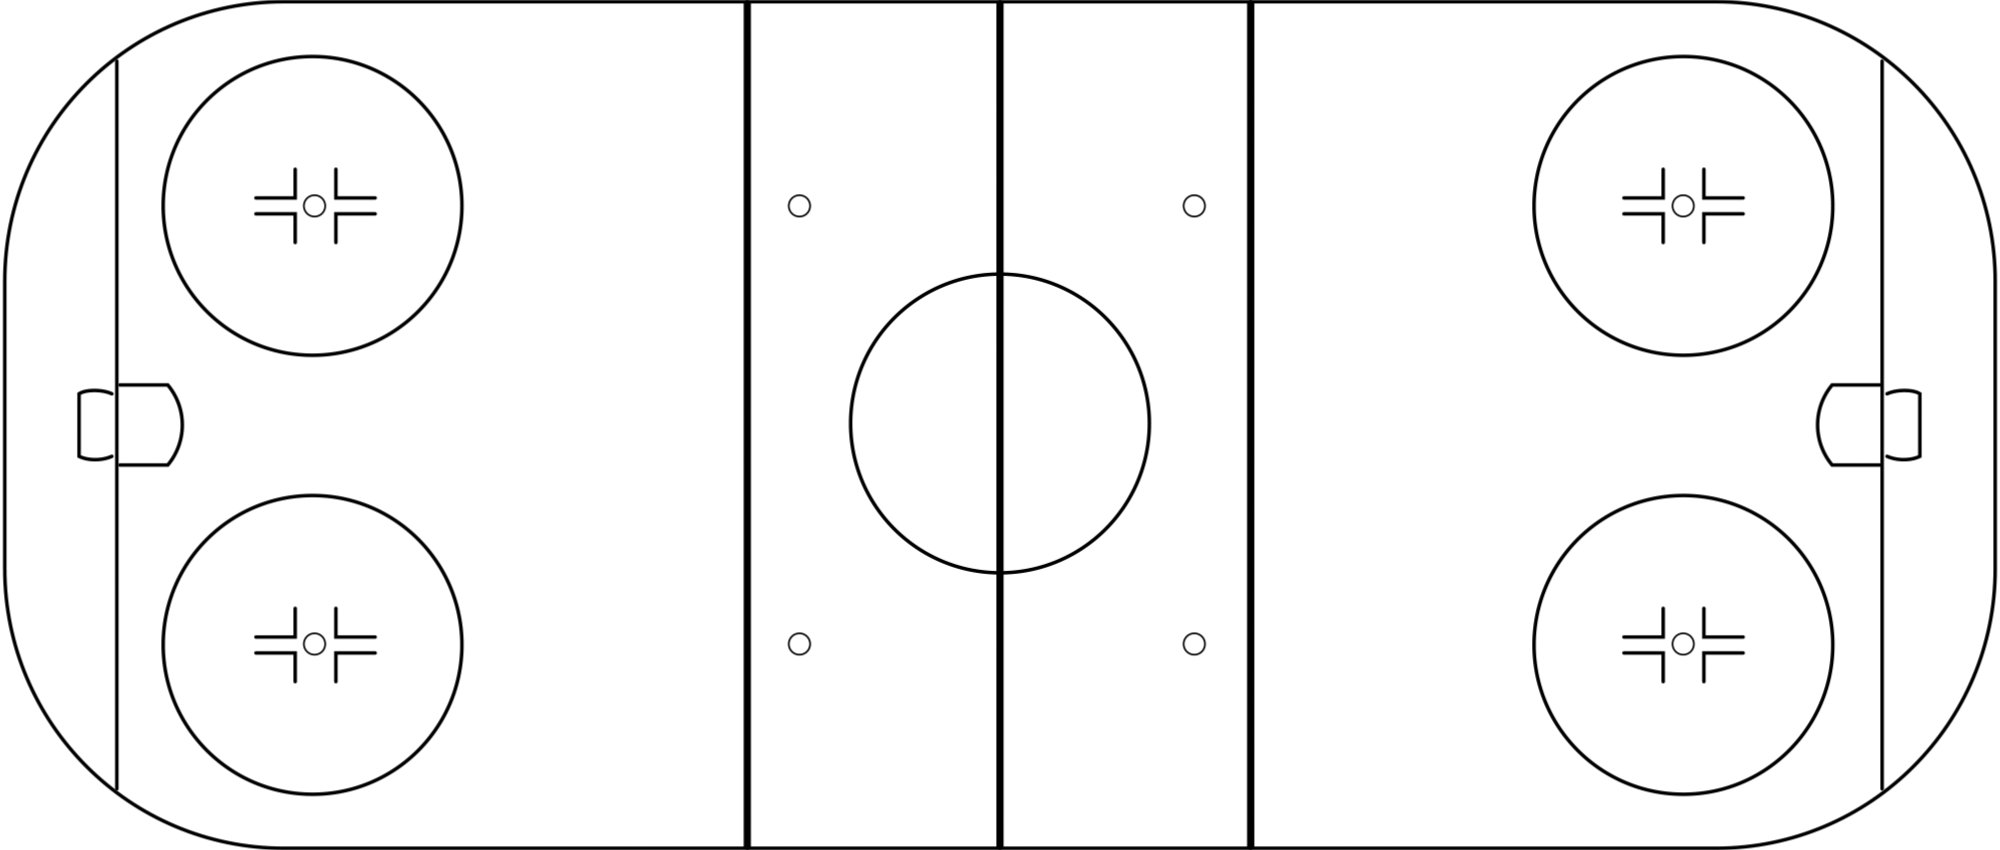

In [167]:
from IPython.display import Image
Image(filename='rink_template.png')

### Data Dictionary

- There are two data files & a rink template for scatter plots. One data file has a condensed event set from a randomly chosen hockey game and the other contains Expected Goals values (xG) to be merged onto shot attempts in the game. If an xG value does not correspond to a shot event, it should not be counted

- X and Y Coordinates are in Feet and are adjusted such that both teams attack from left (dz) to right (oz)
    - X values range from -100 (end boards behind the DZ net) to 0 (centre ice) and 100 (end boards behind the OZ net)
    - Y values range from -42.5 (west side boards) to 0 (centre ice) and 42.5 (east side boards)
    - When creating scatter plots, please use these coordinates along with the provided rink_template to display the full rink

- Binary columns that have values of 0 or 1 indicate 0=No, 1=Yes

- Successfull passes are completed passes, successful shots are shots on net

- If "DZ" or "NZ" are included in a playsection, it is not part of the Offensive Zone

- "All strengths" refers to **all manpowersituations**, as opposed to limiting to even strength, powerplay, or shorthanded situations

- Compiledgametime is in seconds, periods are 20 minutes long, except for overtime which is 5 minutes or less

### Import Libraries

In [343]:
import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import scipy
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
from sklearn.feature_selection import RFE

### Data Importation

In [29]:
df = pd.read_csv("DA_Tutorial24_Event_Data.csv")

#Load the Rink Template
rink_image = mpimg.imread('rink_template.png')

### 1. Data Exploration

In [3]:
df.head(5)

eventname     outcome              type  compiledgametime  \
0       pass  successful             south          0.733333   
1  reception  successful           regular          1.333333   
2       pass  successful  stretchoffboards          2.566667   
3  reception  successful           regular          3.166667   
4       pass  successful            outlet          5.433333   

         playsection zone manpowersituation  goal  teamid  playerid  \
0      southCenterNZ   nz      evenStrength     0     311    111452   
1      centerPointDZ   dz      evenStrength     0     311        80   
2        westPointDZ   dz      evenStrength     0     311        80   
3  northEastBoardsNZ   nz      evenStrength     0     311    111452   
4        innerSlotDZ   dz      evenStrength     0     315     80264   

   opposingteamgoalieoniceid  xadjcoord  yadjcoord  
0                      80264  -2.316772   9.808823  
1                      80264 -26.457947   6.791176  
2                      80264 -30.481476  30.932352  
3                      80264   3.718521  35.458824  
4                       5152 -81.171463   3.770588

In [4]:
df.nunique()

eventname                       3
outcome                         2
type                           23
compiledgametime             1797
playsection                    22
zone                            3
manpowersituation               3
goal                            2
teamid                          2
playerid                       38
opposingteamgoalieoniceid       2
xadjcoord                    1015
yadjcoord                     391
dtype: int64

In [344]:
# Total game time assuming a regular game has 3 periods of 20 minutes each

period_time = 1200 

# Finding the game time of the winning goal
winning_goal_time = df['compiledgametime'].max()

# Determine the period
if winning_goal_time <= period_time:
    winning_period = 1
elif winning_goal_time <= 2 * period_time:
    winning_period = 2
elif winning_goal_time <= 3 * period_time:
    winning_period = 3
else:
    winning_period = 'Overtime'

print(f"Winning goal was scored in period: {winning_period} \nWinning Goal Time: {winning_goal_time} Seconds")

Winning goal was scored in period: Overtime 
Winning Goal Time: 3838.7666 Seconds


### 2.. Winning Team and Goals Scores

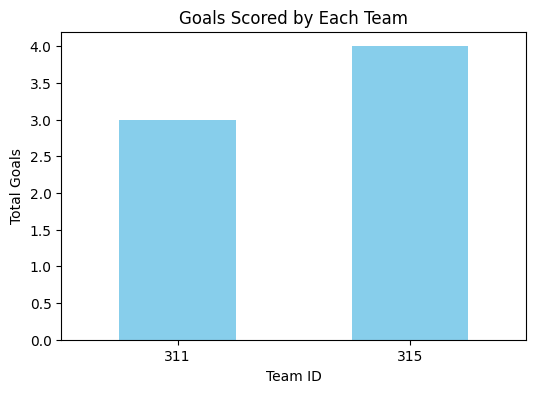

Winning Team: Team ID 315 with 4 goals.


In [345]:
# Group by 'teamid' and sum the 'goal' column

goal_sums = df.groupby('teamid')['goal'].sum()

#print(goal_sums)

plt.figure(figsize=(6, 4))
goal_sums.plot(kind='bar', color='skyblue')
plt.title('Goals Scored by Each Team')
plt.xlabel('Team ID')
plt.ylabel('Total Goals')
plt.xticks(rotation=0)
plt.show()


team_with_highest_goals = goal_sums.idxmax()
highest_goals = goal_sums.max()

print(f"Winning Team: Team ID {team_with_highest_goals} with {highest_goals} goals.")

In [12]:
df[df['goal'] == 1]

eventname     outcome     type  compiledgametime       playsection zone  \
20        shot  successful  outside         38.633335  outsideNorthWest   oz   
309       shot  successful     slot        645.066650     eastOuterSlot   oz   
805       shot  successful  outside       1676.600000       centerPoint   oz   
1132      shot  successful     slot       2365.633300         innerSlot   oz   
1203      shot  successful     slot       2504.266600     westOuterSlot   oz   
1271      shot  successful  outside       2648.433300  outsideNorthWest   oz   
1796      shot  successful  outside       3838.766600  outsideNorthWest   oz   

     manpowersituation  goal  teamid  playerid  opposingteamgoalieoniceid  \
20        evenStrength     1     311    109964                      80264   
309       evenStrength     1     315     79380                       5152   
805          powerPlay     1     315     79380                       5152   
1132      evenStrength     1     311    370192                      80264   
1203         powerPlay     1     311    370192                      80264   
1271      evenStrength     1     315     81408                       5152   
1796         powerPlay     1     315     81408                       5152   

      xadjcoord  yadjcoord  
20    80.157722 -13.326469  
309   65.687363  21.373528  
805   46.971462  10.814705  
1132  77.262863  -1.258823  
1203  68.087128 -12.823528  
1271  87.313828  -8.299999  
1796  62.562599 -25.900000

In [13]:
df['outcome'].unique()

array(['successful', 'failed'], dtype=object)

### 3. Goals Scored in Different Periods 

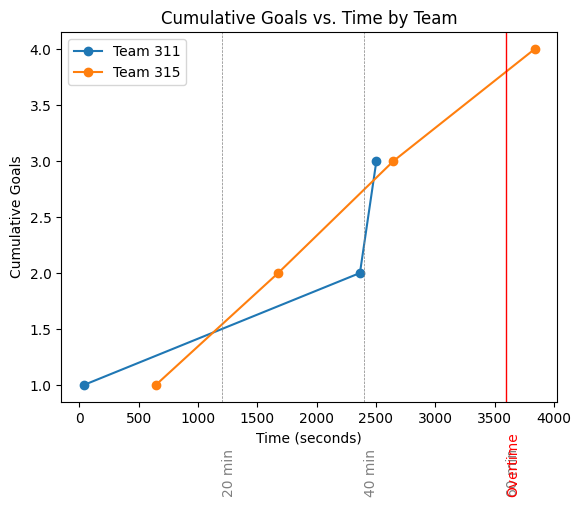

In [14]:
# Define period lengths
period_length = 20 * 60  # 20 minutes in seconds
overtime_start = 3 * period_length

# Assign periods
def assign_period(time):
    if time < period_length:
        return '1st Period'
    elif time < 2 * period_length:
        return '2nd Period'
    elif time < 3 * period_length:
        return '3rd Period'
    else:
        return 'Overtime'

df['period'] = df['compiledgametime'].apply(assign_period)

# Sort by compiledgametime
df = df.sort_values(by='compiledgametime')

# Filter out rows where goal is 0
df_goals = df[df['goal'] == 1]

# Calculate cumulative goals for each team
df_goals['cumulative_goal'] = df_goals.groupby('teamid')['goal'].cumsum()

# Plotting
fig, ax = plt.subplots()

# Plot lines for each team
for team in df_goals['teamid'].unique():
    team_data = df_goals[df_goals['teamid'] == team]
    ax.plot(team_data['compiledgametime'], team_data['cumulative_goal'], marker='o', label=f'Team {team}')

# Add vertical lines to indicate periods
for period_end in range(period_length, 3 * period_length + 1, period_length):
    ax.axvline(x=period_end, color='grey', linestyle='--', linewidth=0.5)
    ax.text(period_end, 0, f'{period_end // 60} min', rotation=90, verticalalignment='bottom', color='grey')

# Highlight overtime
ax.axvline(x=overtime_start, color='red', linestyle='-', linewidth=1)
ax.text(overtime_start, 0, 'Overtime', rotation=90, verticalalignment='bottom', color='red')

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Cumulative Goals')
ax.set_title('Cumulative Goals vs. Time by Team')
ax.legend()
plt.show()

### 4. Shots Attempts by Winning Team in Overtime

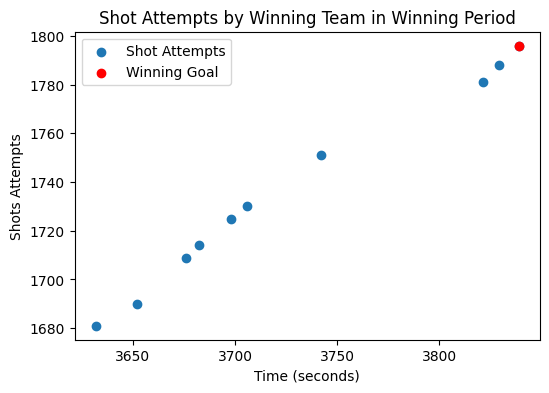

In [15]:
# Filter for the winning team's shot attempts in the period of the winning goal
winning_team_id = df[df['goal'] == 1]['teamid'].value_counts().index[0]
winning_goal_time = df[df['goal'] == 1]['compiledgametime'].value_counts().index[-1]
winning_period = (winning_goal_time // 1200) + 1  # Period calculation

# Filter shot attempts by the winning team in the winning period
shots_in_winning_period = df[(df['teamid'] == winning_team_id) & 
                             (df['eventname'] == 'shot') & 
                             (df['compiledgametime'] > 3600)]

# Separate the winning goal for highlighting
winning_goal = df[(df['goal'] == 1) & (df['teamid'] == 315) & (df['period'] == 'Overtime')]

# Create the scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(shots_in_winning_period['compiledgametime'], shots_in_winning_period.index, label='Shot Attempts')
plt.scatter(winning_goal['compiledgametime'], winning_goal.index, color='red', label='Winning Goal')

# Add labels and legend
plt.xlabel('Time (seconds)')
plt.ylabel('Shots Attempts')
plt.title('Shot Attempts by Winning Team in Winning Period')
plt.legend()
plt.show()

In [16]:
failed_attempts = df['outcome'] == 'failed'
team_315 = df['teamid'] == 315
after_3rd = df['compiledgametime'] > 3600
shots = df['eventname'] == 'shot'

failed_attempt = len(df[failed_attempts & team_315 & after_3rd & shots])

print(f'Failed Shot Attempts by Winning Team in Overtime: {failed_attempt}')
df[failed_attempts & team_315 & after_3rd & shots]

Failed Shot Attempts by Winning Team in Overtime: 4


eventname outcome            type  compiledgametime    playsection zone  \
1681      shot  failed            slot         3631.8000  westOuterSlot   oz   
1751      shot  failed  outsideblocked         3742.1000      westPoint   oz   
1781      shot  failed     slotblocked         3821.4333  westOuterSlot   oz   
1788      shot  failed     slotblocked         3829.3000  westOuterSlot   oz   

     manpowersituation  goal  teamid  playerid  opposingteamgoalieoniceid  \
1681         powerPlay     0     315     81408                       5152   
1751         powerPlay     0     315     81408                       5152   
1781         powerPlay     0     315     81408                       5152   
1788         powerPlay     0     315     81408                       5152   

      xadjcoord  yadjcoord    period  
1681  60.543015 -21.373528  Overtime  
1751  38.924404 -35.958824  Overtime  
1781  60.550873 -21.876472  Overtime  
1788  59.544991 -20.367645  Overtime

### 5. Player that Scored Winning Goal

In [17]:
winning_goal_player = df[(df['compiledgametime'] > 3600) & df['goal'] == 1]['playerid']
print(f"Winning Goal Scorer: Player ID {winning_goal_player.values[0]}")

Winning Goal Scorer: Player ID 81408


In [25]:
# Filter data for shots, power play, and player 81408
data = df.copy()
shots = data['eventname'] == 'shot'
powerplay = data['manpowersituation'] == 'powerPlay'
player_81408 = data['playerid'] == 81408

filtered_data = data[shots & powerplay & player_81408]
print(f'Shots Attempts by this player are {len(filtered_data)}')

Shots Attempts by this player are 15


In [27]:
filtered_data.head(3)

eventname     outcome            type  compiledgametime       playsection  \
111      shot  successful            slot         236.93333     westOuterSlot   
138      shot      failed  outsideblocked         306.90000  outsideNorthWest   
411      shot  successful            slot         895.83330     eastOuterSlot   

    zone manpowersituation  goal  teamid  playerid  opposingteamgoalieoniceid  \
111   oz         powerPlay     0     315     81408                       5152   
138   oz         powerPlay     0     315     81408                       5152   
411   oz         powerPlay     0     315     81408                       5152   

     xadjcoord  yadjcoord      period  
111  60.665802 -21.376471  1st Period  
138  57.640305 -35.458824  1st Period  
411  54.630508 -21.657959  1st Period

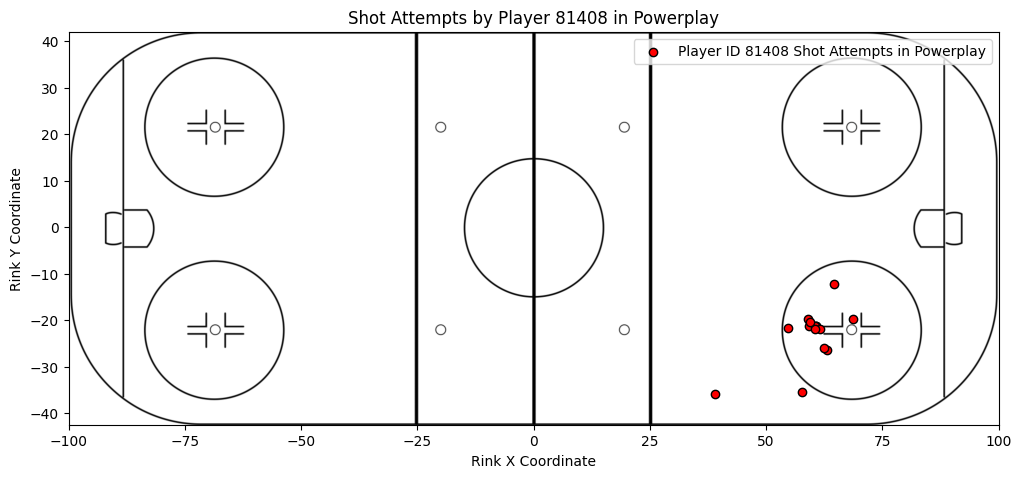

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the rink template
ax.imshow(rink_image, extent=[-100, 100, -42.5, 42,5])  # Adjust extent as per the rink template dimensions

filtered_data
# Scatter plot for shot attempts by this player in Powerplay
ax.scatter(filtered_data['xadjcoord'], filtered_data['yadjcoord'], c='red', label=f'Player ID {winning_goal_player.values[0]} Shot Attempts in Powerplay', edgecolors='black')

# Set labels and title
ax.set_xlabel('Rink X Coordinate')
ax.set_ylabel('Rink Y Coordinate')
ax.set_title('Shot Attempts by Player 81408 in Powerplay')
ax.legend()

# Show the plot
plt.show()

### 7. Shot Attemps based on Ovi's Office 

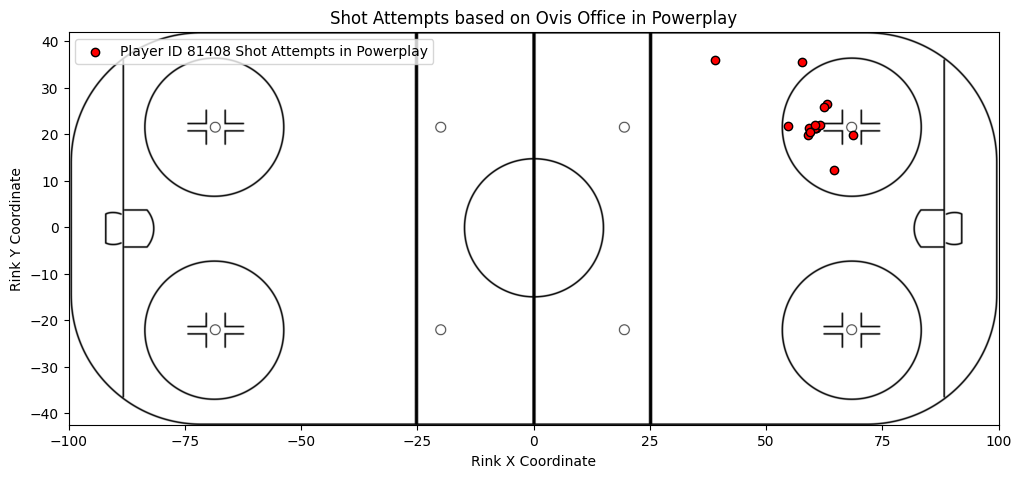

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))

adjusted_df = filtered_data.copy()
# Plot the rink template
ax.imshow(rink_image, extent=[-100, 100, -42.5, 42,5])  # Adjust extent as per the rink template dimensions

adjusted_df['adjusted_y'] = filtered_data['yadjcoord'].apply(lambda y: abs(y))


# Scatter plot for shot attempts by this player in Powerplay
ax.scatter(adjusted_df['xadjcoord'], adjusted_df['adjusted_y'], c='red', label=f'Player ID {winning_goal_player.values[0]} Shot Attempts in Powerplay', edgecolors='black')

# Set labels and title
ax.set_xlabel('Rink X Coordinate')
ax.set_ylabel('Rink Y Coordinate')
ax.set_title('Shot Attempts based on Ovis Office in Powerplay')
ax.legend()

# Show the plot
plt.show()

### 8. Overall Match Statistics 

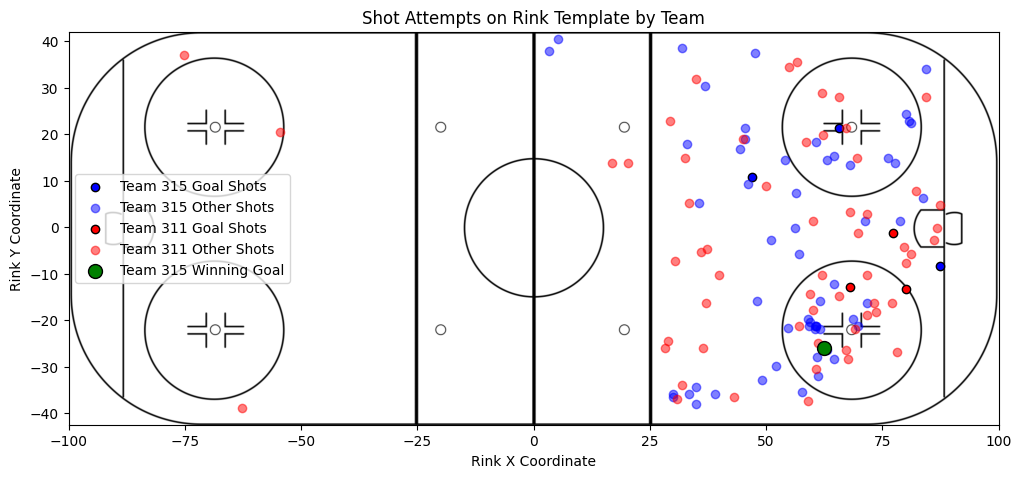

In [47]:
# Create the Scatter Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the rink template
ax.imshow(rink_image, extent=[-100, 100, -42.5, 42,5]) 

# Filter data for shots
shots = data[data['eventname'] == 'shot']

# Define a color map for different teams
team_colors = {
    315: 'blue',
    311: 'red',
    # Add more team colors as needed
}

# Scatter plot for shots by team
for team_id, color in team_colors.items():
    team_shots = shots[shots['teamid'] == team_id]
    goal_shots = team_shots[team_shots['goal'] == 1]
    other_shots = team_shots[team_shots['goal'] == 0]
    
    # Scatter plot for goal shots
    ax.scatter(goal_shots['xadjcoord'], goal_shots['yadjcoord'], c=color, label=f'Team {team_id} Goal Shots', edgecolors='black')

    # Scatter plot for other shots
    ax.scatter(other_shots['xadjcoord'], other_shots['yadjcoord'], c=color, alpha=0.5, label=f'Team {team_id} Other Shots')

    # Highlight the winning goal in a different color for each team
if not winning_shots.empty:
    winning_goal = df[(df['goal'] == 1) & (df['teamid'] == 315)].iloc[-1]  # Assuming the last winning shot is the winning goal
    ax.scatter(winning_goal['xadjcoord'], winning_goal['yadjcoord'], c='green', s=100, edgecolors='black', label=f'Team 315 Winning Goal')

# Set labels and title
ax.set_xlabel('Rink X Coordinate')
ax.set_ylabel('Rink Y Coordinate')
ax.set_title('Shot Attempts on Rink Template by Team')
ax.legend()

# Show the plot
plt.show()

### 9. Even Strength Pass Completion Rate based on Zones

In [48]:
# Filter data for even strength passes
even_strength_passes = df[(df['eventname'] == 'pass') & (df['manpowersituation'] == 'evenStrength')]

# Group by team, zone, and pass completion status
pass_completion_rate = even_strength_passes.groupby(['teamid', 'zone', 'outcome']).size().unstack(fill_value=0)

# Calculate completion rate
pass_completion_rate['completion_rate'] = pass_completion_rate['successful'] / (pass_completion_rate['successful'] + pass_completion_rate['failed'])

# Reset index for plotting
pass_completion_rate.reset_index(inplace=True)

In [56]:
pass_completion_rate

outcome  teamid zone  failed  successful  completion_rate
0           311   dz      40          89         0.689922
1           311   nz       7          30         0.810811
2           311   oz      29          50         0.632911
3           315   dz      37         115         0.756579
4           315   nz      12          28         0.700000
5           315   oz      40          43         0.518072

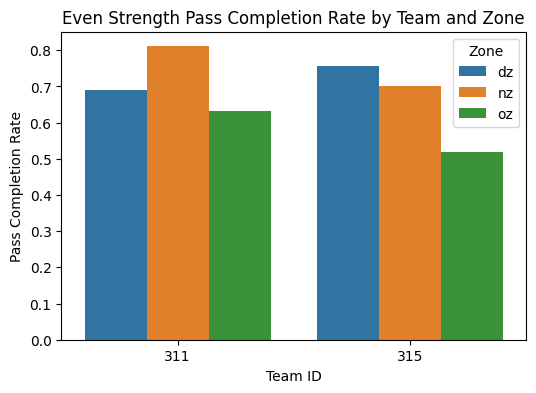

In [50]:
# Create a bar plot
plt.figure(figsize=(6, 4))
sns.barplot(data=pass_completion_rate, x='teamid', y='completion_rate', hue='zone')

# Set plot labels and title
plt.xlabel('Team ID')
plt.ylabel('Pass Completion Rate')
plt.title('Even Strength Pass Completion Rate by Team and Zone')
plt.legend(title='Zone')

# Display the plot
plt.show()

### 10. Team 315's Even Strength Pass Completion in Offensive Zone

In [63]:
# Filter data for team 315 in the offensive zone
team_315_offensive_zone = pass_completion_rate[(pass_completion_rate['teamid'] == 315) & (pass_completion_rate['zone'] == 'oz')]

# Get the completion rate
team_315_offensive_completion_rate = team_315_offensive_zone['completion_rate'].values[0]
print(f'Team 315 even strength pass completion in Offensive Zone is: {round(team_315_offensive_completion_rate, 2)*100} %')

Team 315 even strength pass completion in Offensive Zone is: 52.0 %


### 11. Challenging Zone to Complete Passes at Even Strength

In [66]:
# Calculate average completion rate per zone
zone_completion_rate = pass_completion_rate.groupby('zone')['completion_rate'].mean()

# Find the zone with the lowest completion rate
most_challenging_zone = zone_completion_rate.idxmin()
most_challenging_rate = zone_completion_rate.min()
print(f'Most Challenging Zone: {most_challenging_zone} with {round(most_challenging_rate*100,2)} %')

Most Challenging Zone: oz with 57.55 %


### 12. Team 311's Slot Save Percentage

In [95]:
# Filter data for slot shots 

playsection = df['playsection'].isin(['innerSlot', 'westOuterSlot', 'eastOuterSlot'])
team_311 = df['teamid'] == 311 #team311
slot_save = df['eventname'] == 'reception'#save
outcome_save = df['outcome'] == 'successful' 

team_311_slot_save = df[playsection & team_311 & slot_save & outcome_save]
team_311_slot_total = df[playsection & team_311 & slot_save]

team_311_slot_save_perc = round((len(team_311_slot_save)/len(team_311_slot_total))*100, 2)

print(f'Slot Save Percentage for Team 311: {team_311_slot_save_perc} %')

Slot Save Percentage for Team 311: 96.15 %


### 13. Team 315's Distance of Shots to the Centre of the Net from Outside NorthWest Section

In [100]:
df['playsection'].unique()

array(['southCenterNZ', 'centerPointDZ', 'westPointDZ',
       'northEastBoardsNZ', 'innerSlotDZ', 'outsideNorthWestDZ',
       'southEastBoardsNZ', 'eastPointDZ', 'outsideNorthEastDZ',
       'southWestBoardsNZ', 'westPoint', 'outsideNorthEast',
       'outsideNorthWest', 'northCenterNZ', 'centerPoint', 'innerSlot',
       'westOuterSlotDZ', 'eastOuterSlotDZ', 'eastPoint', 'westOuterSlot',
       'northWestBoardsNZ', 'eastOuterSlot'], dtype=object)

In [104]:
# Calculate distance to center of the net
df['distance_to_net'] = np.sqrt((df['xadjcoord'] - 89)**2 + df['yadjcoord']**2)

# Filter data for team 315's shots on goal from the outside north west playsection
team_315_shots = df[(df['teamid'] == 315) & (df['eventname'] == 'shot') & (df['playsection'] == 'outsideNorthWest')]

# Calculate the average distance
average_distance = round(team_315_shots['distance_to_net'].mean(), 1)
print(f'Avg Distance of shots to the net for Team 315 Outside North West Playsection: {average_distance}')

Avg Distance of shots to the net for Team 315 Outside North West Playsection: 35.6


### 14. Team 315's Goals Saved Above Expected Value from Outside NorthWest Section

In [192]:
# Read expected goals file 
df_xg = pd.read_csv('DA_Tutorial24_xG_Data.csv')

df_merged = pd.merge(df, df_xg, on='compiledgametime', how='outer')
df_merged = df_merged.drop('playerid_y', axis = 1)
df_merged.rename(columns={'playerid_x': 'playerid'}, inplace=True)

In [193]:
df_merged.head(1)

eventname     outcome   type  compiledgametime    playsection zone  \
0      pass  successful  south          0.733333  southCenterNZ   nz   

  manpowersituation  goal  teamid  playerid  opposingteamgoalieoniceid  \
0      evenStrength     0     311    111452                      80264   

   xadjcoord  yadjcoord  distance_to_net  xg  
0  -2.316772   9.808823        91.842071 NaN

In [194]:
df['eventname'].unique(), df['outcome'].unique()

(array(['pass', 'reception', 'shot'], dtype=object),
 array(['successful', 'failed'], dtype=object))

In [195]:
# Filter data for team 315's shots from the outside north west playsection
team_315_shots_saved_outsideNW = df_merged[(df_merged['teamid'] == 311)
                               & (df_merged['eventname'] == 'shot')
                               & (df_merged['type'] == 'outsideblocked')
                               & (df_merged['playsection'] == 'outsideNorthWest')]


# Calculate total expected goals (xG) and actual goals (G)
total_expected_goals_saved = (team_315_shots_saved_outsideNW['xg']-1).sum()
total_actual_goals_saved = team_315_shots_saved_outsideNW.shape[0]

# Calculate Goals Saved Above Expected (GSAx)
gsax =  total_actual_goals_saved - total_expected_goals_saved
gsax = round(gsax, 2)
print(f'Total Actual Goals Saved Above Expected Goals Saved by Team 315 Outside North West Section are: \n{gsax}')

Total Actual Goals Saved Above Expected Goals Saved by Team 315 Outside North West Section are: 
3.98


In [196]:
df_merged.head(5)

eventname     outcome              type  compiledgametime  \
0       pass  successful             south          0.733333   
1  reception  successful           regular          1.333333   
2       pass  successful  stretchoffboards          2.566667   
3  reception  successful           regular          3.166667   
4       pass  successful            outlet          5.433333   

         playsection zone manpowersituation  goal  teamid  playerid  \
0      southCenterNZ   nz      evenStrength     0     311    111452   
1      centerPointDZ   dz      evenStrength     0     311        80   
2        westPointDZ   dz      evenStrength     0     311        80   
3  northEastBoardsNZ   nz      evenStrength     0     311    111452   
4        innerSlotDZ   dz      evenStrength     0     315     80264   

   opposingteamgoalieoniceid  xadjcoord  yadjcoord  distance_to_net  xg  
0                      80264  -2.316772   9.808823        91.842071 NaN  
1                      80264 -26.457947   6.791176       115.657501 NaN  
2                      80264 -30.481476  30.932352       123.420555 NaN  
3                      80264   3.718521  35.458824        92.359400 NaN  
4                       5152 -81.171463   3.770588       170.213231 NaN

#### **Observations**
- This infers that Team 315 performed better than expected when the Team 311 shot from Outside North West section.
- Meanwhile it can also points one towards the poor performance of Team 311.

In [198]:
team_315_shots_saved_outsideNW

eventname outcome            type  compiledgametime       playsection  \
911       shot  failed  outsideblocked         1885.2333  outsideNorthWest   
1502      shot  failed  outsideblocked         3223.4000  outsideNorthWest   

     zone manpowersituation  goal  teamid  playerid  \
911    oz         powerPlay     0     311    111452   
1502   oz      evenStrength     0     311     94531   

      opposingteamgoalieoniceid  xadjcoord  yadjcoord  distance_to_net  \
911                       80264  60.657944 -30.429413        41.583907   
1502                      80264  59.034191 -37.467644        47.976807   

            xg  
911   0.017890  
1502  0.005776

In [241]:
df_merged['eventname'].unique(), df_merged['outcome'].unique()

(array(['pass', 'reception', 'shot'], dtype=object),
 array(['successful', 'failed'], dtype=object))

### 15. Shot Assists

In [258]:
# Create a column for shot assist
df1 = df_merged.copy()
df1['shot_assist'] = False
df1['passerid'] = None

# Iterate through the DataFrame to flag shot assists
for x in range(2, len(df)):
    if (df1.loc[x-2, 'eventname'] == 'pass' and 
        df1.loc[x-2, 'outcome'] == 'successful' and
        df1.loc[x-1, 'eventname'] == 'reception' and
        df1.loc[x-1, 'outcome'] == 'successful' and
        df1.loc[x, 'eventname'] == 'shot' and
        df1.loc[x-2, 'teamid'] == df1.loc[x-1, 'teamid'] == df1.loc[x, 'teamid']):
        
        df1.loc[x, 'shot_assist'] = True
        df1.loc[x, 'passerid'] = df1.loc[x-2, 'playerid']

# Count the number of assisted shot attempts for playerid 79380
assisted_shots_player_79380 = df1[(df1['playerid'] == 79380) & (df1['shot_assist'])].shape[0]
print(f"Assisted shot attempts by Player ID 79380: {assisted_shots_player_79380} shots")

Assisted shot attempts by Player ID 79380: 7 shots


### 16. Passer ID with Most xG with Shot Assists

In [244]:
df1['passerid'].unique()

array([None, 109964, 370192, 113401, 6588, 10534, 79380, 112050, 110409,
       5814, 1312, 111452, 41952, 78625, 94531, 884, 109372, 126723,
       237838, 81408, 110856, 82048, 80518, 54915, 446706, 121680,
       20775372, 56711, 80], dtype=object)

In [ ]:
pd.DataFrame(df1.groupby('passerid')['xg'].sum())

In [248]:
# Group by the passer id and sum the xG values
passer_xg = df1.groupby('passerid')['xg'].sum()

# Identify the passer id with the most xG
top_passer = passer_xg.idxmax()
top_passer_xg = passer_xg.max()
print(f"Passer with most xG via shot assists: {top_passer} with xG: {round(top_passer_xg, 2)}")

Passer with most xG via shot assists: 94531 with xG: 0.66


In [262]:
df1[df1['passerid'] == top_passer]

eventname     outcome            type  compiledgametime  \
552       shot      failed            slot         1120.5667   
591       shot      failed            slot         1208.2000   
663       shot  successful            slot         1369.6000   
693       shot      failed            slot         1427.6666   
713       shot      failed            slot         1469.5667   
725       shot      failed         outside         1489.1666   
911       shot      failed  outsideblocked         1885.2333   
1013      shot  successful         outside         2125.2334   
1075      shot      failed  outsideblocked         2241.8000   
1078      shot      failed         outside         2247.0334   
1137      shot  successful         outside         2371.2666   
1555      shot      failed         outside         3397.5000   
1570      shot  successful         outside         3416.1333   

           playsection zone manpowersituation  goal  teamid  playerid  \
552          innerSlot   oz         powerPlay     0     311    111452   
591          innerSlot   oz      evenStrength     0     311    109964   
663      westOuterSlot   oz      evenStrength     0     311    370192   
693          innerSlot   oz         powerPlay     0     311    112050   
713      eastOuterSlot   oz         powerPlay     0     311    370192   
725   outsideNorthEast   oz         powerPlay     0     311    370192   
911   outsideNorthWest   oz         powerPlay     0     311    111452   
1013  outsideNorthWest   oz         powerPlay     0     311    370192   
1075         westPoint   oz      evenStrength     0     311        80   
1078  outsideNorthEast   oz      evenStrength     0     311        80   
1137   westOuterSlotDZ   oz      evenStrength     0     311      6588   
1555       centerPoint   oz      evenStrength     0     311    111452   
1570  outsideNorthWest   oz         powerPlay     0     311    370192   

      opposingteamgoalieoniceid  xadjcoord  yadjcoord  distance_to_net  \
552                       80264  81.163605  -5.782352         9.738824   
591                       80264  82.284424   7.794117        10.288208   
663                       80264  65.687363 -14.838236        27.634260   
693                       80264  69.718750  -1.258823        19.322299   
713                       80264  62.174637  19.864708        33.379735   
725                       80264  65.687363  27.911766        36.366822   
911                       80264  60.657944 -30.429413        41.583907   
1013                      80264  61.168747 -24.897058        37.342230   
1075                      80264  37.019714 -16.347059        54.490150   
1078                      80264  56.634415  35.455879        48.006775   
1137                      80264 -54.507702  20.367599       144.945851   
1555                      80264  33.384193   5.282352        55.866101   
1570                      80264  67.584190 -28.414703        35.581347   

            xg  shot_assist passerid  
552   0.160784         True    94531  
591   0.201196         True    94531  
663   0.047423         True    94531  
693   0.076269         True    94531  
713   0.033910         True    94531  
725   0.035003         True    94531  
911   0.017890         True    94531  
1013  0.032598         True    94531  
1075  0.018114         True    94531  
1078  0.004899         True    94531  
1137  0.003141         True    94531  
1555  0.009030         True    94531  
1570  0.022434         True    94531

### 17. Top Passer's Shot Assists 

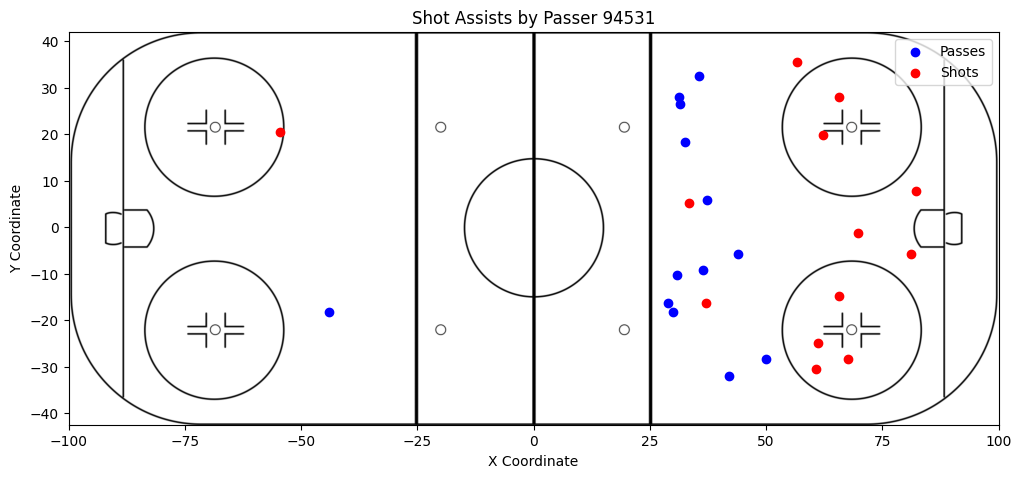

In [269]:
# Filter the DataFrame for the top passer's shot assists
top_passer_shot_assists = df1[df1['passerid'] == top_passer]

# Separate the passes and shots
passes = df1[df1.index.isin(top_passer_shot_assists.index - 2)]
shots = top_passer_shot_assists[top_passer_shot_assists['eventname'] == 'shot']


# Create the Scatter Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the rink template
ax.imshow(rink_image, extent=[-100, 100, -42.5, 42,5]) 

plt.scatter(passes['xadjcoord'], passes['yadjcoord'].apply(lambda y: y), color='blue', label='Passes')
plt.scatter(shots['xadjcoord'], shots['yadjcoord'].apply(lambda y: y), color='red', label='Shots')

plt.title(f'Shot Assists by Passer {top_passer}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()

### 18. Average Time Diff from Reception to Shot for Shot Assists

In [270]:
# Calculate the time difference between reception and shot for shot assists
df1['shot_assist_time_diff'] = None

# Identify the shot assists and calculate the time difference
for x in range(2, len(df1)):
    if (df1.loc[x-2, 'eventname'] == 'pass' and 
        df1.loc[x-2, 'outcome'] == 'successful' and
        df1.loc[x-1, 'eventname'] == 'reception' and 
        df1.loc[x-1, 'outcome'] == 'successful' and 
        df1.loc[x, 'eventname'] == 'shot' and
        df1.loc[x-1, 'playerid'] == df1.loc[x, 'playerid']):
        
        df1.at[x, 'shot_assist_time_diff'] = df1.loc[x, 'compiledgametime'] - df1.loc[x-1, 'compiledgametime']

# Filter the DataFrame to only include rows with a calculated time difference
shot_assists = df1.dropna(subset=['shot_assist_time_diff'])

# Calculate the average time from reception to shot for each shooter with more than one assisted shot
average_time_diff = shot_assists.groupby('playerid')['shot_assist_time_diff'].mean()
shooters_with_multiple_shots = shot_assists['playerid'].value_counts()[shot_assists['playerid'].value_counts() > 1].index
average_time_diff = average_time_diff[average_time_diff.index.isin(shooters_with_multiple_shots)]

# Identify the shooter with the longest average time
longest_average_time_playerid = average_time_diff.idxmax()
longest_average_time = average_time_diff.max()

# Display the result
print(f"The player with the longest average time from receptions to shots is {longest_average_time_playerid} with an average time of {longest_average_time:.2f} seconds.")

# If you also want to display the average times for all shooters with more than one assisted shot:
print("Average time from receptions to shots for shooters with more than one assisted shot:")
print(average_time_diff)

The player with the longest average time from receptions to shots is 112050 with an average time of 3.16 seconds.
Average time from receptions to shots for shooters with more than one assisted shot:
playerid
80          0.733350
884         0.255533
6588        0.661072
78625       2.849950
79380       1.185751
80518       1.366667
81408       0.302213
82048       0.833333
94531       0.971443
109964      0.526647
111452      0.440008
112050      3.155517
126723      0.033320
179172      0.083350
202206      2.683350
370192      0.508325
400162      0.400000
1731661     2.599945
20775372    0.955567
Name: shot_assist_time_diff, dtype: float64


### 19. Team with highest xG

In [277]:
# Calculate the total xG for each team
team_xg = df1.groupby('teamid')['xg'].sum()

# Identify the team with the highest xG
winning_teamid = team_xg.idxmax()
team_xg_winning = team_xg.max()

# Display the winning team
print(f"The team that won the all strengths xG battle is teamid {winning_teamid} with {team_xg_winning:.2f}.")

The team that won the all strengths xG battle is teamid 311 with 5.15.


### 20. Losing Team's xG

In [278]:
# Identify the team with the lowest xG
losing_teamid = team_xg.idxmin()
losing_team_xg = team_xg.min()

# Round the losing team's xG to 2 decimal places
losing_team_xg_rounded = round(losing_team_xg, 2)

# Display the losing team's xG
print(f"The losing team's all strengths xG is {losing_team_xg_rounded}.")

The losing team's all strengths xG is 4.1.


#### **Observations**
- This suggests that Team 311 would perform better than Team 315, but in the actual game Team 315 won.
- The xG values were inversly proportional to Team 311's performance in the game.
- Team 315 performed according to the xG values.

In [284]:
df1.columns

Index(['eventname', 'outcome', 'type', 'compiledgametime', 'playsection',
       'zone', 'manpowersituation', 'goal', 'teamid', 'playerid',
       'opposingteamgoalieoniceid', 'xadjcoord', 'yadjcoord',
       'distance_to_net', 'xg', 'shot_assist', 'passerid',
       'shot_assist_time_diff'],
      dtype='object')

### 21. Creation of New Features

In [287]:
df1['previous_event'] = df1['eventname'].shift(1)
df1['pass_distance'] = np.sqrt((df1['xadjcoord'] - df1['xadjcoord'].shift(1))**2 + (df1['yadjcoord'] - df1['yadjcoord'].shift(1))**2)

In [342]:
df1.head(2)

eventname  outcome  type  compiledgametime  playsection  zone  \
0          0        1    19          0.733333           15     1   
1          1        1    15          1.333333            1     0   

   manpowersituation  goal  teamid  playerid  opposingteamgoalieoniceid  \
0                  0     0     311    111452                      80264   
1                  0     0     311        80                      80264   

   xadjcoord  yadjcoord  distance_to_net  xg  shot_assist  passerid  \
0  -2.316772   9.808823        91.842071 NaN        False        28   
1 -26.457947   6.791176       115.657501 NaN        False        28   

   shot_assist_time_diff  previous_event  pass_distance  
0                     71               3            NaN  
1                     71               0      24.329046

### 22. Univariate Analysis

In [331]:
numeric_df = df1.select_dtypes(include=['number'])

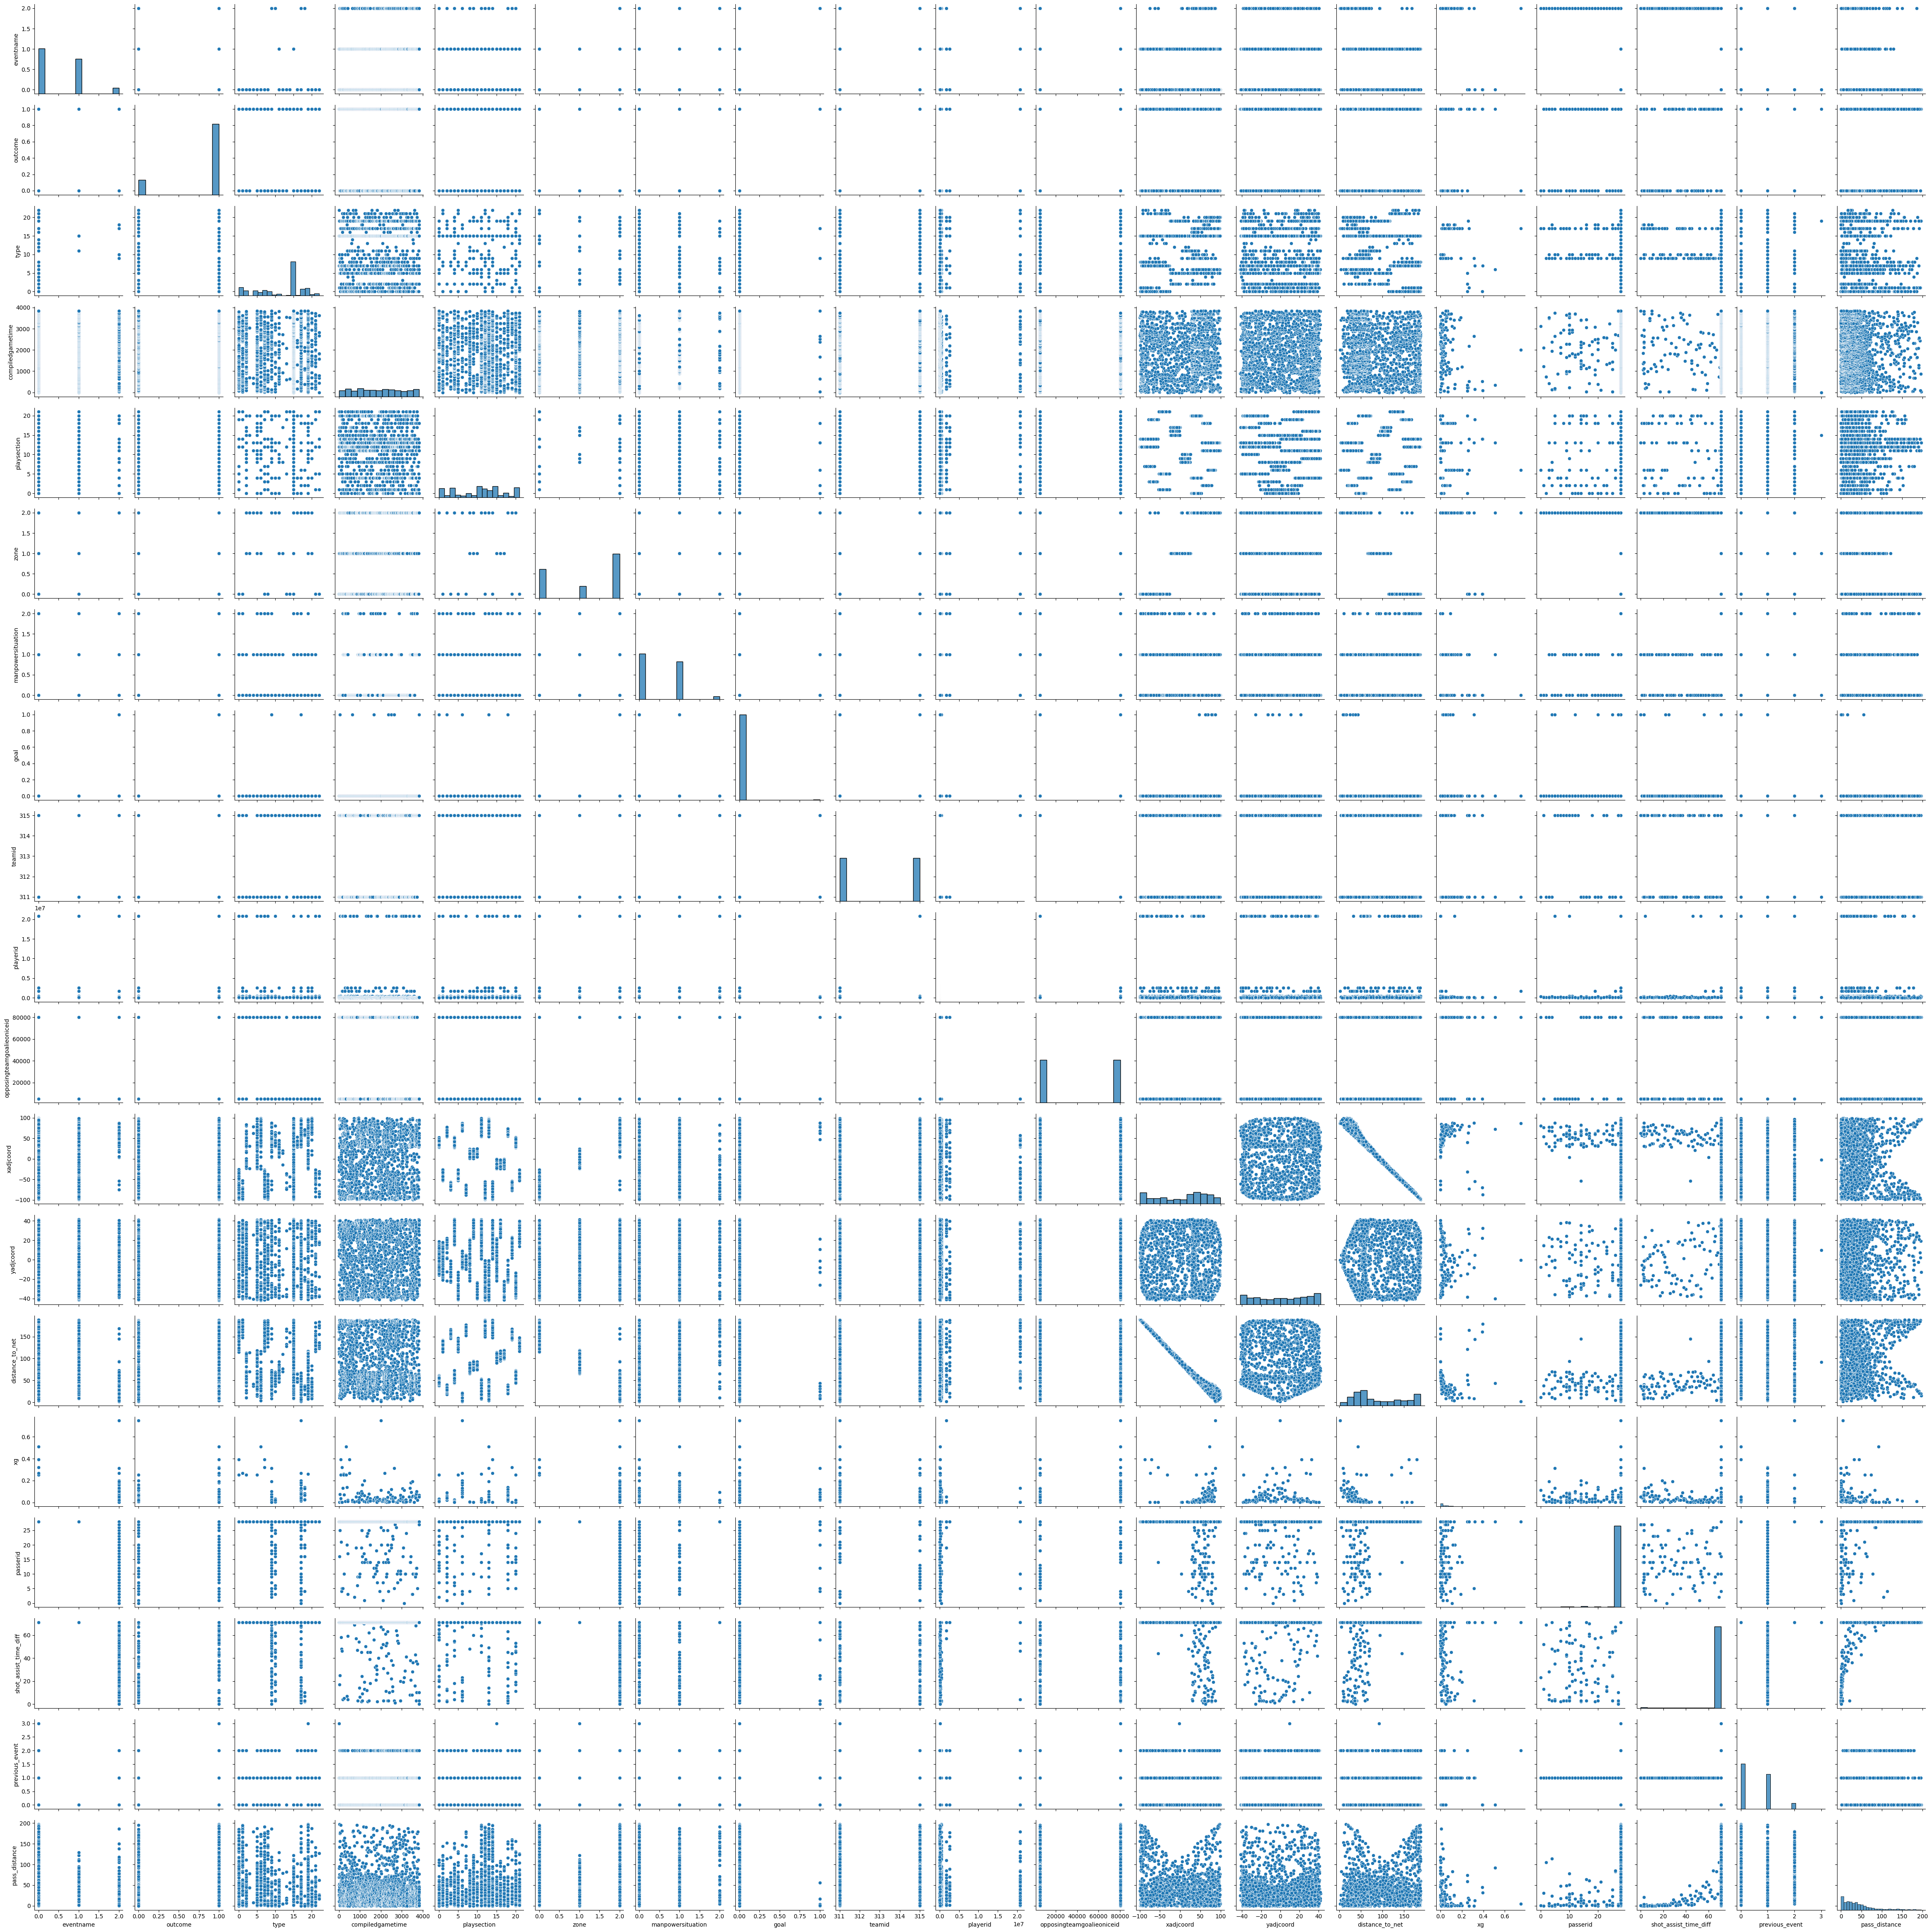

In [332]:
sns.pairplot(numeric_df)
plt.show()

### 23. Feature Importance

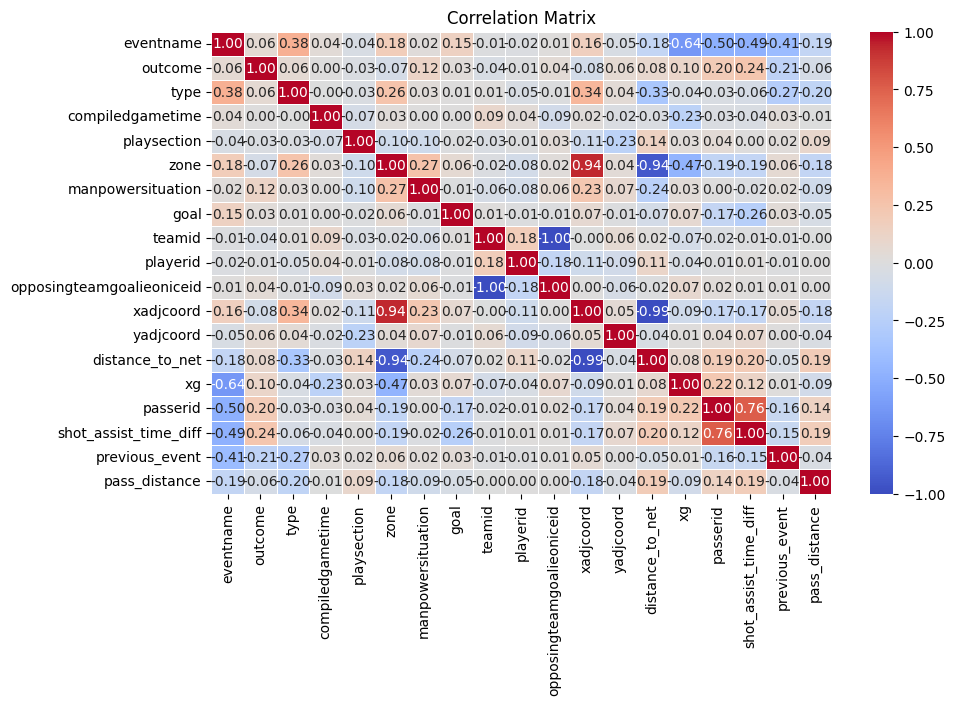

In [335]:
# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [309]:
# Encoding categorical variables
label_encoders = {}
for column in df1.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df1[column] = le.fit_transform(df1[column])
    label_encoders[column] = le

# Impute missing values with 0
imputer = SimpleImputer(strategy='constant', fill_value=0)
df_imputed = pd.DataFrame(imputer.fit_transform(df1), columns=df1.columns)

# Define features and target
features = df_imputed.drop(columns=['goal', 'xg'])
target = df_imputed['goal']

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(features, target)

# Extract feature importances
importances = model.feature_importances_
feature_names = features.columns

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
FeaImp_list= feature_importances['Feature'].tolist()
print(f'The Features {FeaImp_list[0:3]} are highest predictors from left to right.')
feature_importances[0:6]

The Features ['compiledgametime', 'distance_to_net', 'shot_assist_time_diff'] are highest predictors from left to right.


Feature  Importance
3        compiledgametime    0.147949
12        distance_to_net    0.146205
15  shot_assist_time_diff    0.121378
10              xadjcoord    0.118261
17          pass_distance    0.092178
14               passerid    0.078638

**Notes:**
- Random Forest naturally provides feature importance scores by measuring the impact of each feature on the prediction accuracy. It does this by looking at how much each feature reduces the impurity (e.g. Gini impurity or entropy) in the nodes of the trees.
- Random Forest is robust, handles different data types, and provides reliable feature importance metrics. It's less likely to overfit compared to single decision trees.

### 24. Results & Recommendations 

**Explanation for Non-technical Manager:**
- The model predicts that ['compiledgametime', 'distance_to_net', 'shot_assist_time_diff'] are highest predictors of the goal scoring, which means these are key features that are correlated to the team's performance. For instance, most of the goals are scored in the middle of the game, and closer the distance to the net, the more the chances of scoring a goal.
- Goals are influenced by the timing within the game. Certain times might be more critical, such as during power plays or just after a faceoff.
- A shorter time between a pass and a shot can catch the defense and goalie off guard, increasing the likelihood of scoring.

**Recommendations:**
- Focus on drills that improve players' ability to get into these high-danger areas 'Near the Net'. Consider implementing more plays designed to get the puck into these positions.
- More shot assists help in scoring a goal, thus, focusing more on shot assist strategies.
- Implement practice drills that emphasize quick passes and immediate shots. Encourage players to take shots immediately after receiving a pass to maintain the element of surprise.

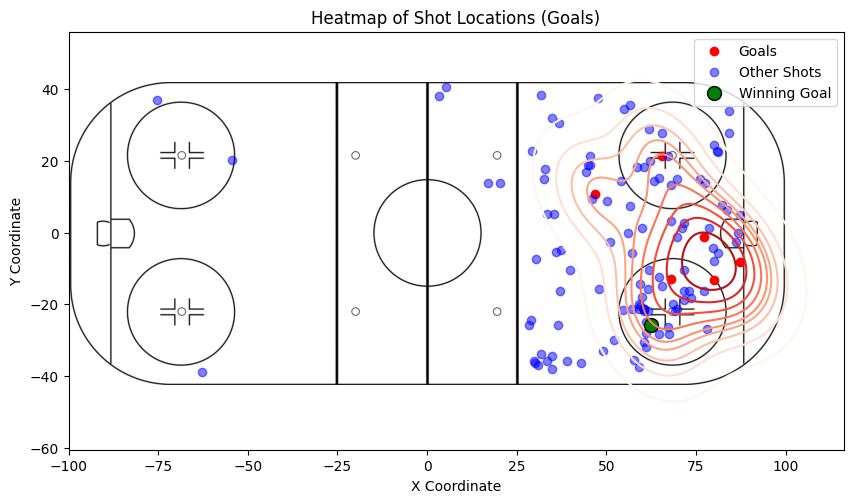

In [349]:
# Heatmap of Shot Locations

# Create the Scatter Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the rink template
ax.imshow(rink_image, extent=[-100, 100, -42.5, 42,5]) 

# Plot the shot coordinates
shots = data[data['eventname'] == 'shot']
winning_shots = shots[shots['goal'] == 1]
other_shots = shots[shots['goal'] == 0]

# Scatter plot for winning shots
ax.scatter(winning_shots['xadjcoord'], winning_shots['yadjcoord'], c='red', label='Goals')

# Scatter plot for other shots
ax.scatter(other_shots['xadjcoord'], other_shots['yadjcoord'], c='blue', alpha=0.5, label='Other Shots')

# Highlight the winning goal in a different color
winning_goal = winning_shots.iloc[-1]  # Assuming the last winning shot is the winning goal
ax.scatter(winning_goal['xadjcoord'], winning_goal['yadjcoord'], c='green', s=100, edgecolors='black', label='Winning Goal')

sns.kdeplot(x=df1[df1['goal'] == 1]['xadjcoord'], y=df1[df1['goal'] == 1]['yadjcoord'], shade=False, cmap='Reds')
plt.title('Heatmap of Shot Locations (Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
ax.legend()
plt.show()

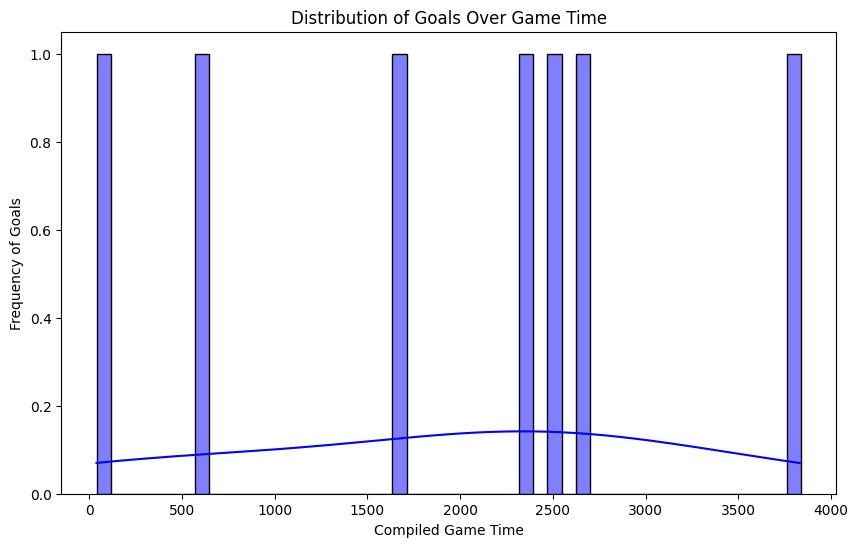

In [337]:
# Timeline of Goals
plt.figure(figsize=(10, 6))
sns.histplot(df1[df1['goal'] == 1]['compiledgametime'], bins=50, kde=True, color='blue')
plt.title('Distribution of Goals Over Game Time')
plt.xlabel('Compiled Game Time')
plt.ylabel('Frequency of Goals')
plt.show()

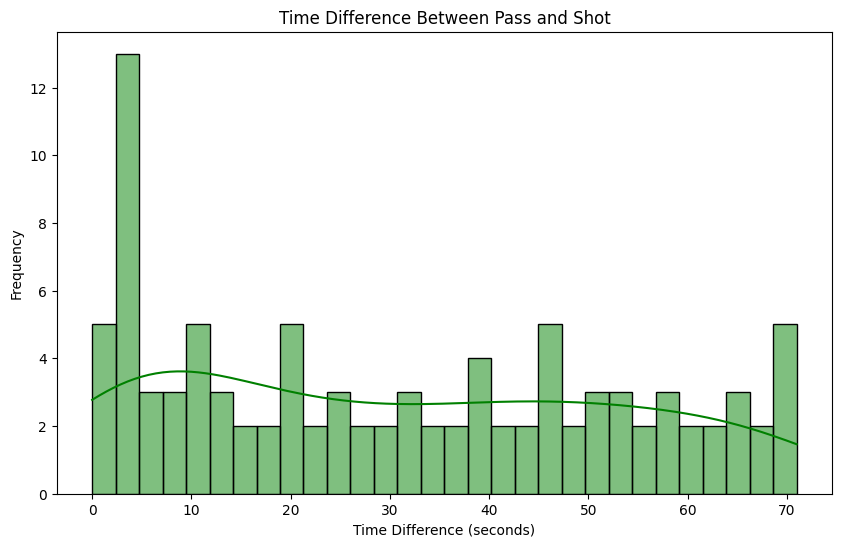

In [321]:
# Pass-to-Shot Timing Analysis
plt.figure(figsize=(10, 6))
sns.histplot(df1[df1['shot_assist'] == True]['shot_assist_time_diff'], bins=30, kde=True, color='green')
plt.title('Time Difference Between Pass and Shot')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.show()

### 25. Future Work: Seasonal Dataset Optimal Predictive Models

In [347]:
seasonal_models = ['GBM', 'Random Forest Reg', 'Logistic Reg', 'Neural Network']
seasonal_models

['GBM', 'Random Forest Reg', 'Logistic Reg', 'Neural Network']

- Random Forest: Robust, interpretable, and handles a large number of features well.
- Gradient Boosting Machines (GBM): Effective for handling various types of data and achieving high predictive accuracy.
- Logistic Regression: A simpler model that provides good interpretability and baseline performance for classification problems.


**Reasoning for Model Choices:**

- Gradient Boosting Machine (GBM): GBMs are powerful ensemble models that can handle complex data structures and interactions well. They often provide high predictive accuracy and can be tuned for better performance. It's great for understanding the influence of different features on the prediction outcome, similar to Random Forest, but often with better performance.

- Random Forest is robust, handles different data types, and provides reliable feature importance metrics. It's less likely to overfit compared to single decision trees. It serves as a strong baseline model due to its simplicity and effectiveness.

- Logistic: While simpler than ensemble methods, logistic regression is interpretable and provides a clear understanding of the relationship between features and the probability of scoring a goal. It's useful for baseline comparisons and understanding linear relationships in the data.

- Neural Netorks: Capable of capturing non-linear relationships and complex patterns in data. It has high flexibility and adaptability to various types of data, especially useful with large datasets.

**By testing these models, we can determine which one provides the best balance of predictive accuracy and interpretability for our xG model.**